### Overview

- This notebook is to compare several classification models that can assist with predicting whether a client will default on their loan.

- The dataset used for our analysis was taken from Kaggle and represents information from the Lending Club, an online financial services company.  https://www.kaggle.com/datasets/wordsforthewise/lending-club


In [ ]:
import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import FunctionTransformer, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [3]:
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 30

In [66]:
df_desc = pd.read_csv('lending_club_info.csv')
df_desc

,LoanStatNew,Description
0,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,term,The number of payments on the loan. Values are in months and can be either 36 or 60.
2,int_rate,Interest Rate on the loan
3,installment,The monthly payment owed by the borrower if the loan originates.
4,grade,LC assigned loan grade
5,sub_grade,LC assigned loan subgrade
6,emp_title,The job title supplied by the Borrower when applying for the loan.*
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER"
9,annual_inc,The self-reported annual income provided by the borrower during registration.


In [2]:
df = pd.read_csv('lending_club_loan_two.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [5]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [10]:
#issue_d would be data leakage, we wouldn't know beforehand whether or not a loan would be issued when using our model, 
# so in theory we wouldn't have an issue_date, drop this feature.
df = df.drop('issue_d',axis=1)
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
# Encode target loan_status: Fully Paid-0; Charged Off-1;
df['loan_default'] =  df['loan_status'].apply(lambda x:0 if x=='Fully Paid' else 1 )

## EDA - Exploratory Data Analysis
- Chcek data balance
- Data Processing for data exploration
- Feature analysis

In [13]:
def check_data_balance(series, style="seaborn-pastel"):
  with plt.style.context(style):
    unique = series.value_counts()
    display(unique) #show unique value counts of the target
    plt.pie(unique, explode=[0.05]*len(unique), labels=unique.index, autopct='%1.1f%%');

In [9]:
df_eda = df.copy()
df_eda['earliest_cr_line'] = pd.to_datetime(df_eda['earliest_cr_line'])

Fully Paid     318357
Charged Off     77673
Name: loan_status, dtype: int64

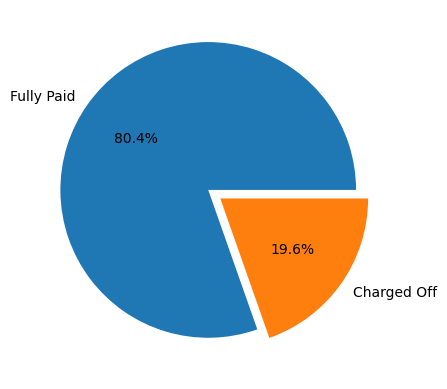

In [8]:
check_data_balance(df_eda['loan_status'], style = 'default')

### Data Processing for EDA
- Drop 'grade' since grade information is included in sub_grade  #df.groupby(['grade','sub_grade']).size()
- emp_title into 4 groups with column emp_title_group <br>
        management(PRESIDENT, Executive, DIRECTOR, MANAGER, SUPERVISOR, OWNER) 
        professional(Teacher, Registered Nurse, RN, Accountant, Engineer, Analyst) 
        law (Police, Attorney) 
        Other 
- verification_status : Verified / Source Verified--1, Not Verified--0
- issue_d: to date type and extract year. 
- loan_status: Fully Paid--0, Charged Off--1
- title: drop title column since it includes similar information like purpose. 
- earliest_cr_line: to date type and extract year 
- address: only keep postcode

In [51]:
temp = df_eda['emp_title'].unique()
[ title for title in temp if str(title).upper().find('MANAGER')>-1 or str(title).upper().find('DIRECTOR')>-1 \
 or str(title).upper().find('PRESIDENT')>-1 or str(title).upper().find('SUPERVISOR')>-1 
]

['Director Bureau of Equipment Inventory',
 'Social Work/Care Manager',
 'Office Manager',
 'Operations Manager',
 'Shift Supervisor',
 'Payroll Manager',
 'Branch Manager',
 'Executive Manager',
 'Global Account Director',
 'Program Manager',
 'Sales Manager',
 'Store manager',
 'Resident Service Director',
 'Director special projects',
 'Vice President',
 'Transportation manager',
 'manager',
 'FSQA Supervisor II',
 'Manager Maintenance, Compliance',
 'Assistant Store Director',
 'Case Manager',
 'social service supervisor',
 'Project manager ',
 'IT Process Manager',
 'Assistant General Manager',
 'Manager',
 'Supervisor',
 'Lab Director',
 'Director',
 'Lending Manager 2',
 'Project manager',
 'Technical Director',
 'Executive Director, IT and Datacenter',
 'Ferry Terminal Manager I',
 'Director Information Technology',
 'Site Manager',
 'Billing Manager',
 'Executive Director',
 'General Manager',
 'Marketing Manager',
 'Fulfillment Manager',
 'Manager of Engineering',
 'Human Res

In [52]:
df_eda['application_type'].value_counts()

INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64

In [21]:
df_eda['loan_status'].value_counts()

Fully Paid     318357
Charged Off     77673
Name: loan_status, dtype: int64

In [22]:
df_eda['title'].nunique()

48817

### Missing Data

In [53]:
100 * df_eda.isnull().sum() / len(df)

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_default            0.000000
dtype: float64

In [4]:
def get_emp_title_group(emp_title):
    #emp_title_group = np.nan
    #if emp_title is not None and emp_title is not np.nan :
    emp_title = str(emp_title)
    if emp_title.upper().find('MANAGER')>-1 or emp_title.upper().find('DIRECTOR')>-1 \
        or emp_title.upper().find('PRESIDENT')>-1 or emp_title.upper().find('SUPERVISOR')>-1 \
        or emp_title.upper().find('EXECUTIVE')>-1 or emp_title.upper().find('OWNER')>-1 :
        emp_title_group = 'Management'
    elif emp_title.upper().find('TEACHER')>-1 or emp_title.upper().find('NURSE')>-1 \
        or emp_title.upper().find('RN ')>-1 or emp_title.upper().find('ACCOUNTANT')>-1 \
        or emp_title.upper().find('ENGINEER')>-1 or emp_title.upper().find('ANALYST')>-1 :
        emp_title_group = 'Professional'
    elif emp_title.upper().find('POLICE')>-1 or emp_title.upper().find('ATTORNEY')>-1 \
        or emp_title.upper().find('OFFICER')>-1 or emp_title.upper().find('LAWYER')>-1:
        emp_title_group = 'Law'
    else:
        emp_title_group = 'Other'
            
    return emp_title_group
        

In [11]:
df_eda['emp_title_group'] = df_eda['emp_title'].apply(get_emp_title_group)
df_eda['earliest_cr_line_year'] = df_eda['earliest_cr_line'].dt.year
df_eda['term_month'] = df_eda['term'].apply(lambda term: int(term[:3]))
df_eda['verification_status'] = df_eda['verification_status'].apply(lambda x:0 if x=='Not Verified' else 1 )
df_eda['postcode'] = df_eda['address'].apply(lambda address: address[-5:])

In [12]:
df_eda

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,dti,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,loan_default,emp_title_group,earliest_cr_line_year,term_month,postcode
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,0,Fully Paid,vacation,Vacation,26.24,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690",0,Other,1990,36,22690
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,0,Fully Paid,debt_consolidation,Debt consolidation,22.05,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113",0,Professional,2004,36,05113
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,1,Fully Paid,credit_card,Credit card refinancing,12.79,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113",0,Other,2007,36,05113
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,0,Fully Paid,credit_card,Credit card refinancing,2.60,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813",0,Other,2006,36,00813
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,1,Charged Off,credit_card,Credit Card Refinance,33.95,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650",1,Other,1999,60,11650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,60 months,10.99,217.38,B,B4,licensed bankere,2 years,RENT,40000.0,1,Fully Paid,debt_consolidation,Debt consolidation,15.63,...,6.0,0.0,1990.0,34.3,23.0,w,INDIVIDUAL,0.0,0.0,"12951 Williams Crossing\r\nJohnnyville, DC 30723",0,Other,2004,60,30723
396026,21000.0,36 months,12.29,700.42,C,C1,Agent,5 years,MORTGAGE,110000.0,1,Fully Paid,debt_consolidation,Debt consolidation,21.45,...,6.0,0.0,43263.0,95.7,8.0,f,INDIVIDUAL,1.0,0.0,"0114 Fowler Field Suite 028\r\nRachelborough, LA 05113",0,Other,2006,36,05113
396027,5000.0,36 months,9.99,161.32,B,B1,City Carrier,10+ years,RENT,56500.0,1,Fully Paid,debt_consolidation,pay off credit cards,17.56,...,15.0,0.0,32704.0,66.9,23.0,f,INDIVIDUAL,0.0,0.0,"953 Matthew Points Suite 414\r\nReedfort, NY 70466",0,Other,1997,36,70466
396028,21000.0,60 months,15.31,503.02,C,C2,"Gracon Services, Inc",10+ years,MORTGAGE,64000.0,1,Fully Paid,debt_consolidation,Loanforpayoff,15.88,...,9.0,0.0,15704.0,53.8,20.0,f,INDIVIDUAL,5.0,0.0,"7843 Blake Freeway Apt. 229\r\nNew Michael, FL 29597",0,Other,1990,60,29597


<AxesSubplot:xlabel='emp_title_group', ylabel='annual_inc'>

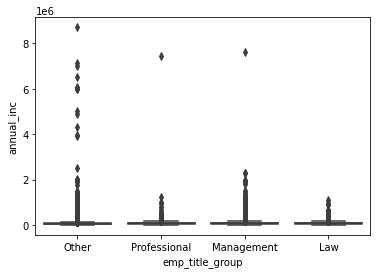

In [13]:
sns.boxplot(x='emp_title_group', y='annual_inc', data=df_eda)

In [57]:
df_eda.groupby('emp_title_group')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
emp_title_group,,,,,,,,
Law,7922.0,89052.999732,53940.448376,13000.00,56000.0,79000.0,105000.0,1100000.0
Management,66346.0,91260.408411,68418.886699,7900.00,56000.0,78000.0,110000.0,7600000.0
Other,290320.0,69413.731656,60135.325627,0.00,42000.0,60000.0,83000.0,8706582.0
Professional,31442.0,78692.456478,54317.421424,7459.64,55000.0,72000.0,95000.0,7446395.0


In [14]:
target = ['loan_default']
categorical_vars = ['term','sub_grade','emp_length','home_ownership', 'verification_status','purpose', \
                    'initial_list_status','application_type', 'emp_title_group', 'postcode']
discrete_vars = ['earliest_cr_line_year','open_acc','pub_rec','total_acc','mort_acc','pub_rec_bankruptcies']
continuous_vars = ['loan_amnt', 'int_rate','installment','annual_inc','dti','revol_bal','revol_util']

In [15]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   loan_amnt              396030 non-null  float64       
 1   term                   396030 non-null  object        
 2   int_rate               396030 non-null  float64       
 3   installment            396030 non-null  float64       
 4   grade                  396030 non-null  object        
 5   sub_grade              396030 non-null  object        
 6   emp_title              373103 non-null  object        
 7   emp_length             377729 non-null  object        
 8   home_ownership         396030 non-null  object        
 9   annual_inc             396030 non-null  float64       
 10  verification_status    396030 non-null  int64         
 11  loan_status            396030 non-null  object        
 12  purpose                396030 non-null  obje

<Figure size 1152x1080 with 0 Axes>

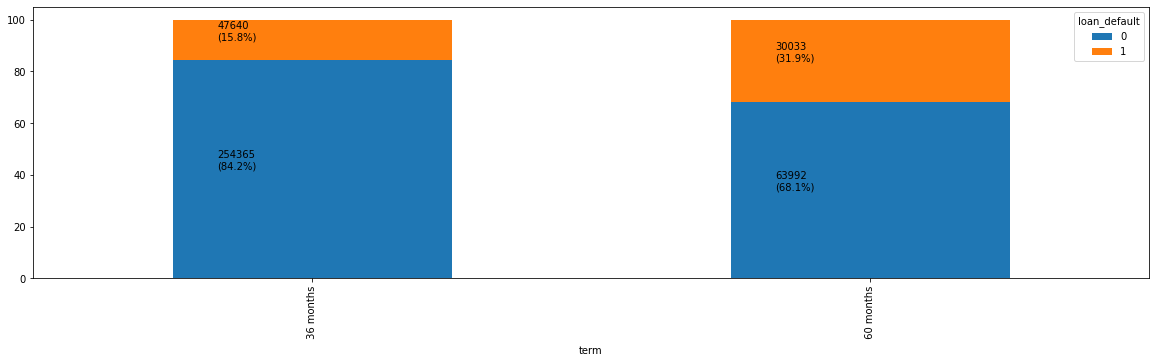

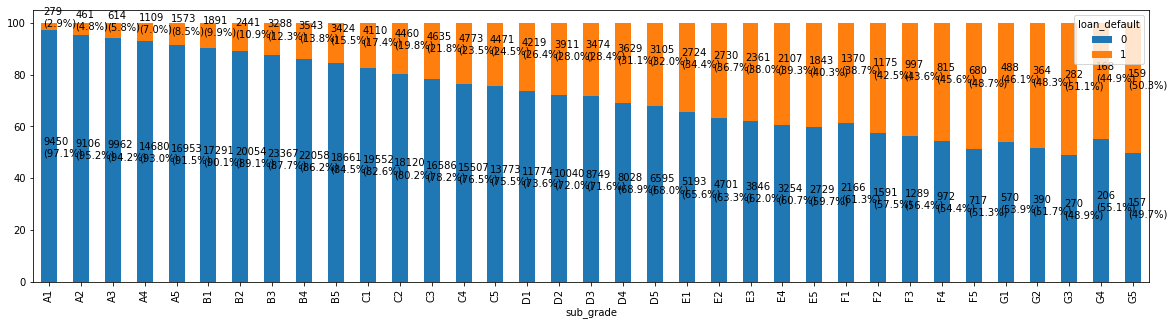

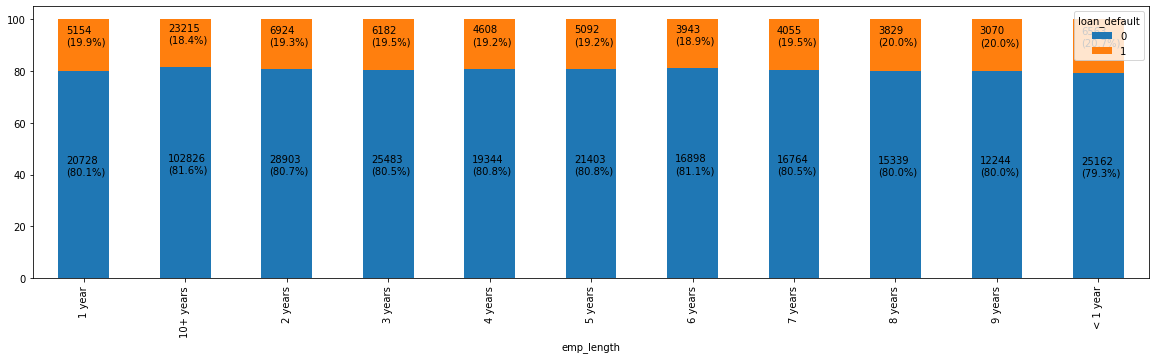

posx and posy should be finite values
posx and posy should be finite values


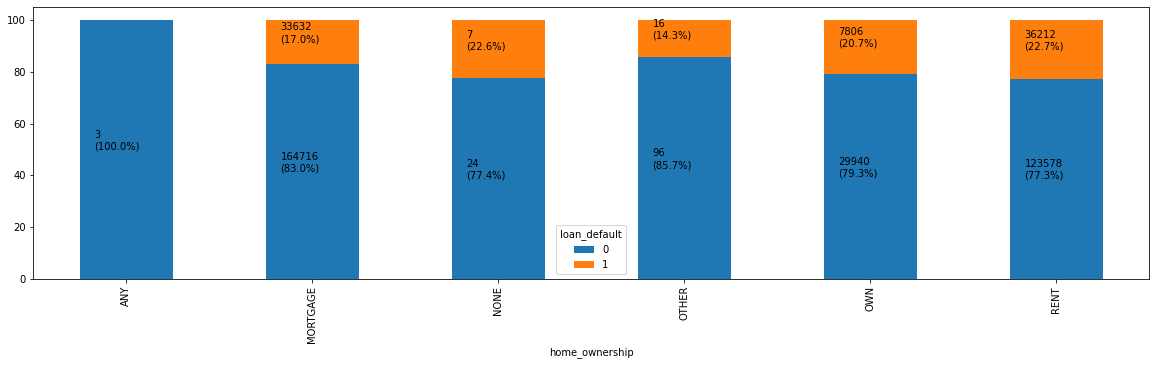

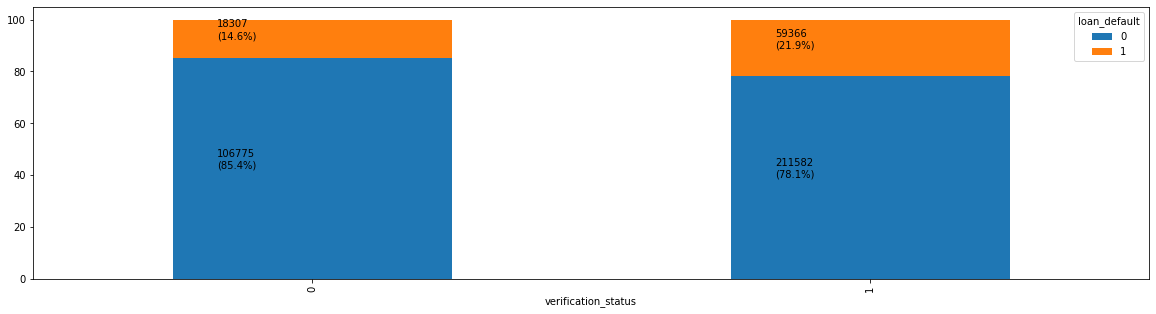

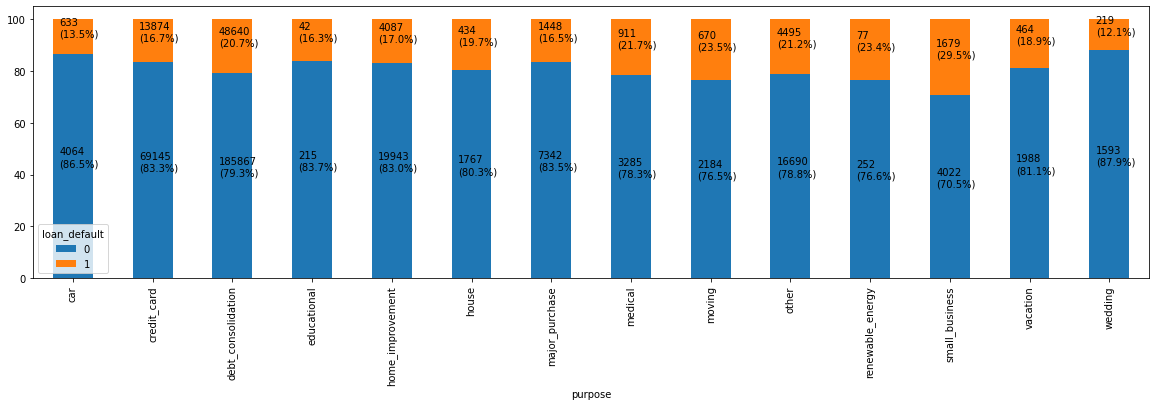

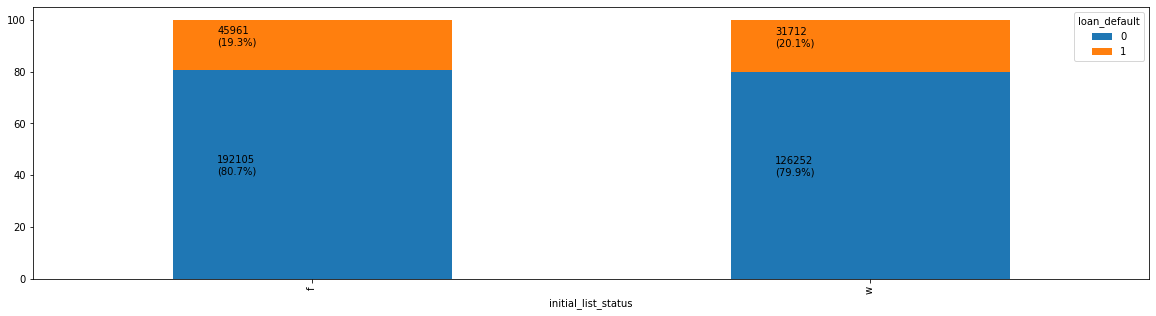

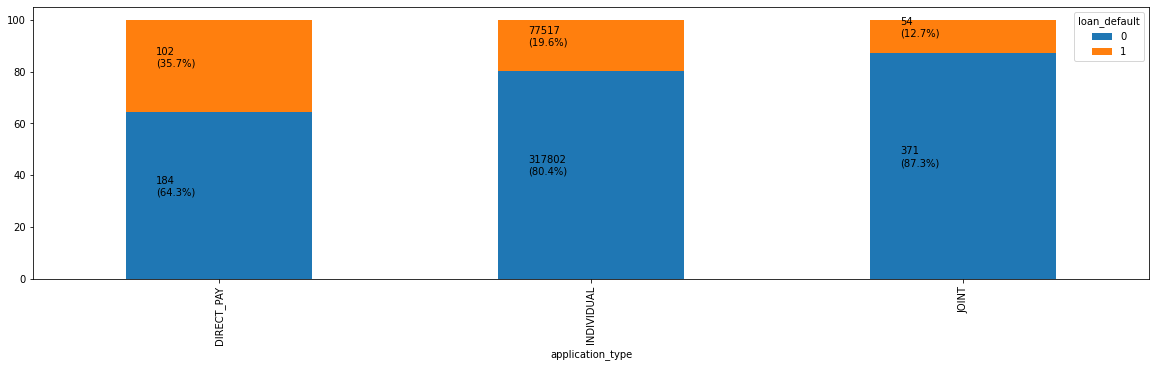

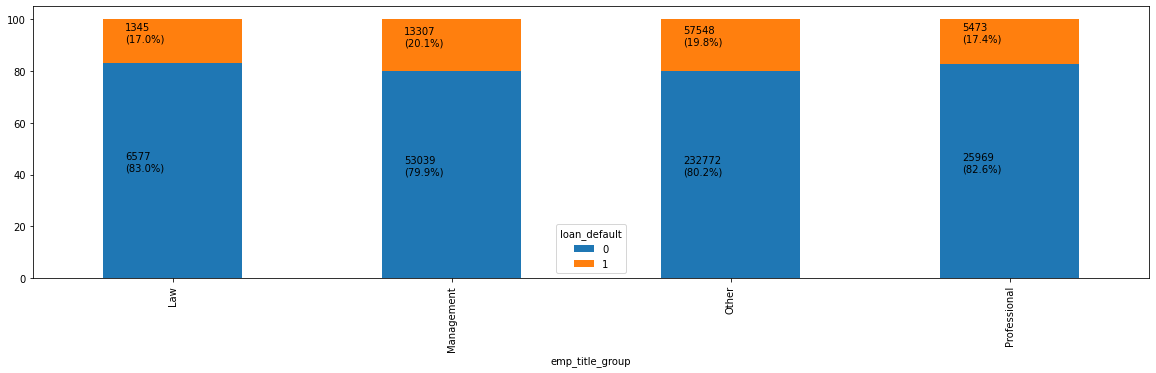

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


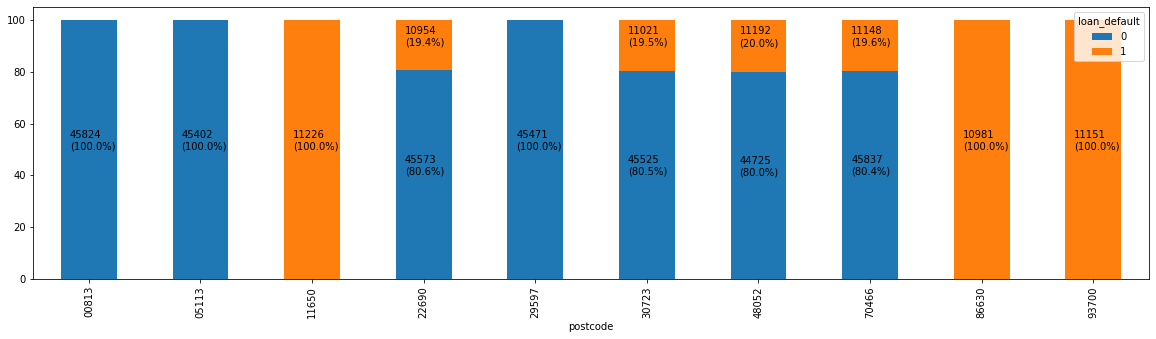

In [16]:
# 100% stack bar chart

plt.figure(figsize=(16, 15))

for i, col in enumerate(categorical_vars):

    # Group by 'loan_status' and the categorical column, then count the occurrences
    g_counts = df_eda.groupby([col, 'loan_default']).size()
    g_counts_unstake = g_counts.unstack(level=1)
    #print(g_counts_unstake.head(10))

    # Convert the counts to percentages by dividing by the sum and multiplying by 100
    g_percentages = (g_counts / g_counts.groupby(level=0).sum()) * 100
    g_percentages_unstake = g_percentages.unstack(level=1)
    
    #######################################################################
    g_percentages_unstake.plot(kind='bar', 
                            stacked=True, 
                           #colormap='tab10', 
                           figsize=(20, 5)
                            )

    for n, x in enumerate([*g_counts_unstake.index.values]):
        for (proportion, count, y_loc) in zip(g_percentages_unstake.loc[x],
                                              g_counts_unstake.loc[x],
                                              g_percentages_unstake.loc[x].cumsum()):            

            if count is None or np.isnan(count):
                count = 0

            plt.text(x=n - 0.17,
                     y=(y_loc - proportion) + (proportion / 2),
                     s=f'{int(count)}\n({np.round(proportion, 1)}%)', 
                     color="black",
                     fontsize=10
                   #  ,fontweight="bold"
                    )



<AxesSubplot:>

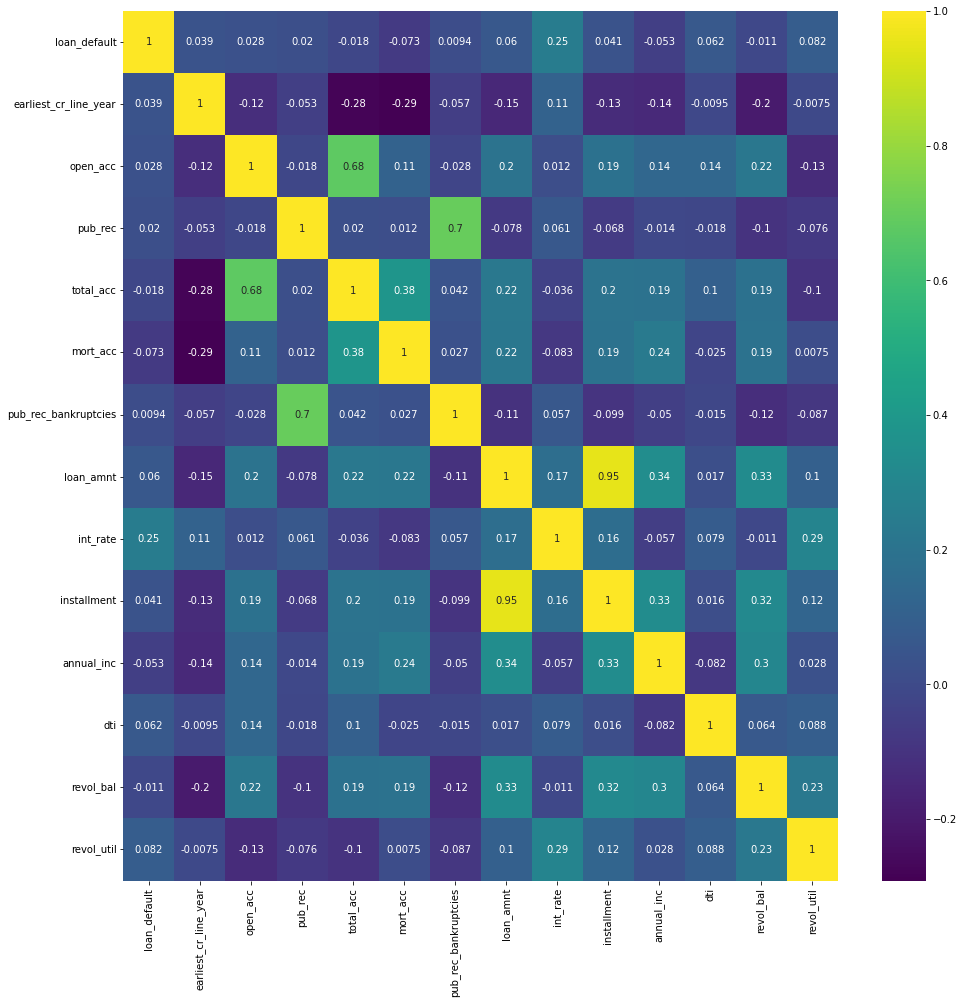

In [17]:
plt.figure(figsize=(16,16))
sns.heatmap(df_eda.loc[:, ['loan_default'] + discrete_vars + continuous_vars].corr(),annot=True,cmap='viridis')

<AxesSubplot:>

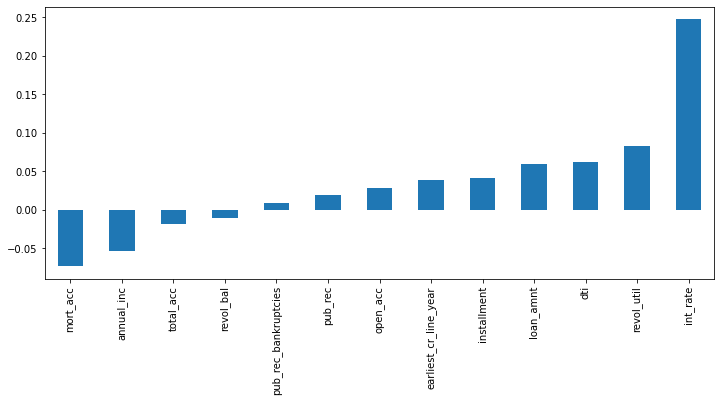

In [18]:
df_eda.loc[:, ['loan_default'] + discrete_vars + continuous_vars].corr().loc['loan_default'] \
    .sort_values().drop('loan_default').plot(kind = 'bar', figsize = (12,5))

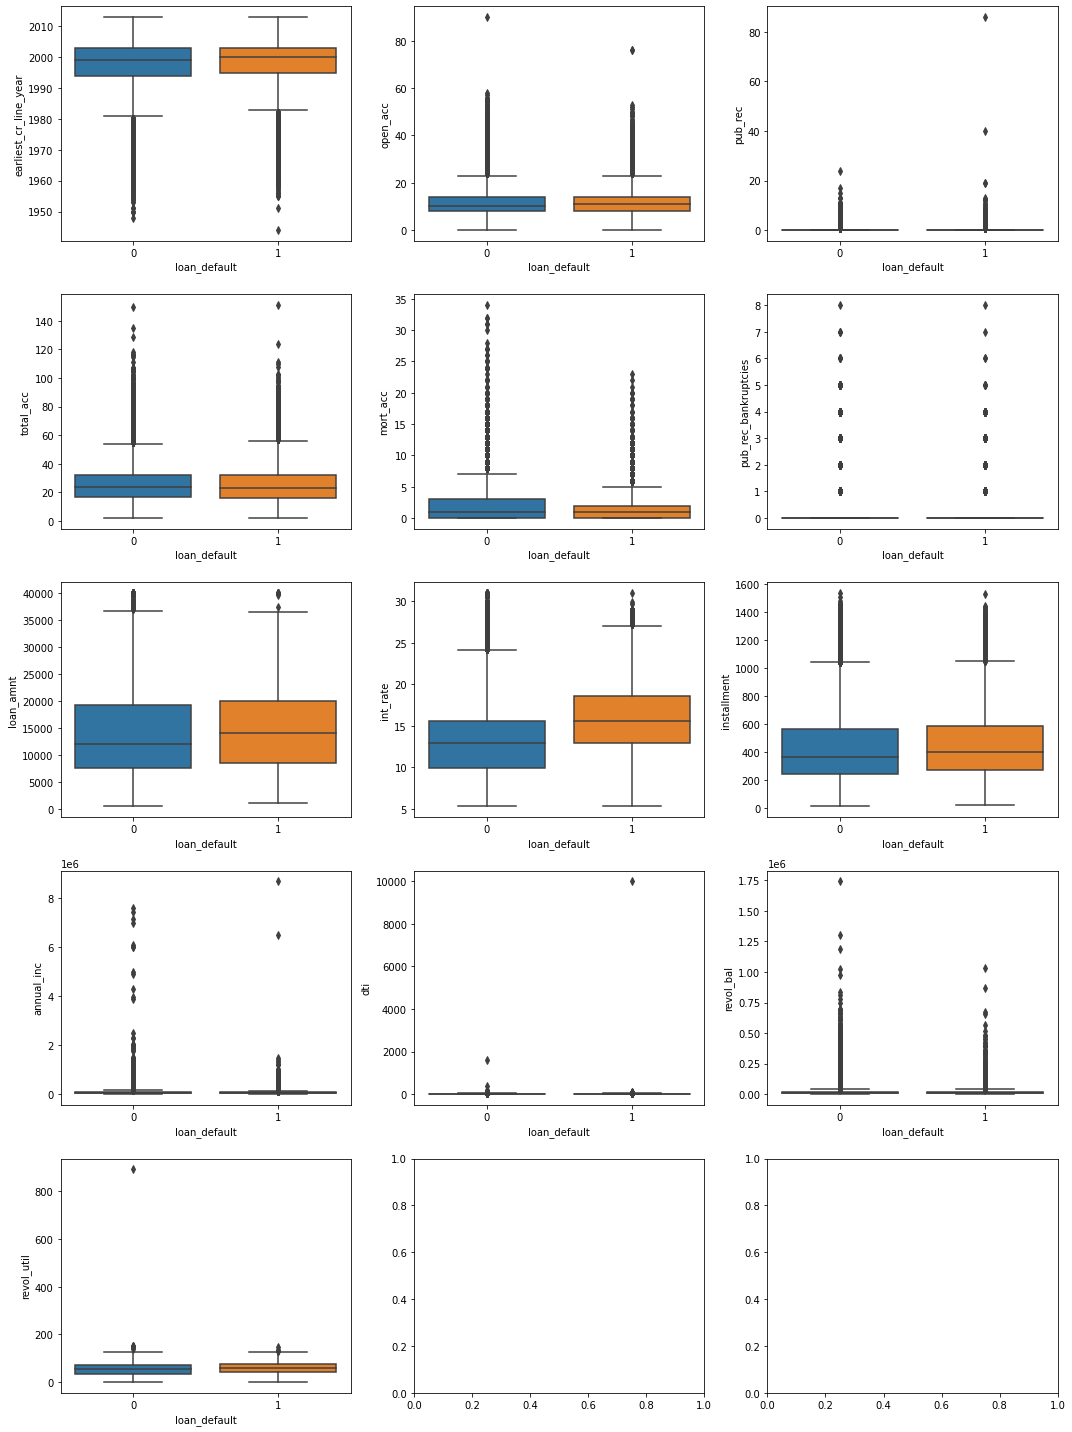

In [19]:
fig, axes = plt.subplots(5, 3, figsize=(15, 20))

# Flatten the array of axes for easier indexing
axes_flat = axes.flatten()

for i, col in enumerate(discrete_vars+continuous_vars):
    # Check if the index is within the range of axes available to avoid IndexError
    if i < len(axes_flat):
        sns.boxplot(x=target[0], y=col, data=df_eda.loc[:, target + discrete_vars + continuous_vars], ax=axes_flat[i])
    else:
        print(f"No axis available for {col}")

# Adjust layout for better spacing between plots
plt.tight_layout()

###  Features analysis
Categorical Features
- emp_length and initial_list_status can't contribute too much explaination to target, thus drop these two columns. 
- home_ownership data has invalide data, need to validate data in data precessing pipeline before train and test model. 

Numeric Features
- int_rate has strongest correlation to target.
- loan_amnt and installement has strong corrlation to each other (0.95), loan_amnt contributes more target explaination, thus drop installement.

### Missing Data Imputation
- fill emp_title_group as 'Other'
- emp_length: Drop the column
- revol_util: correlated with int_rate and revol_bal, fill value with linear regression.
- mort_acc: has correlation with 'total_acc', fill value with linear regression.
- pub_rec_bankruptcies: correlated with 'pub_rec', fill value with linear regression.

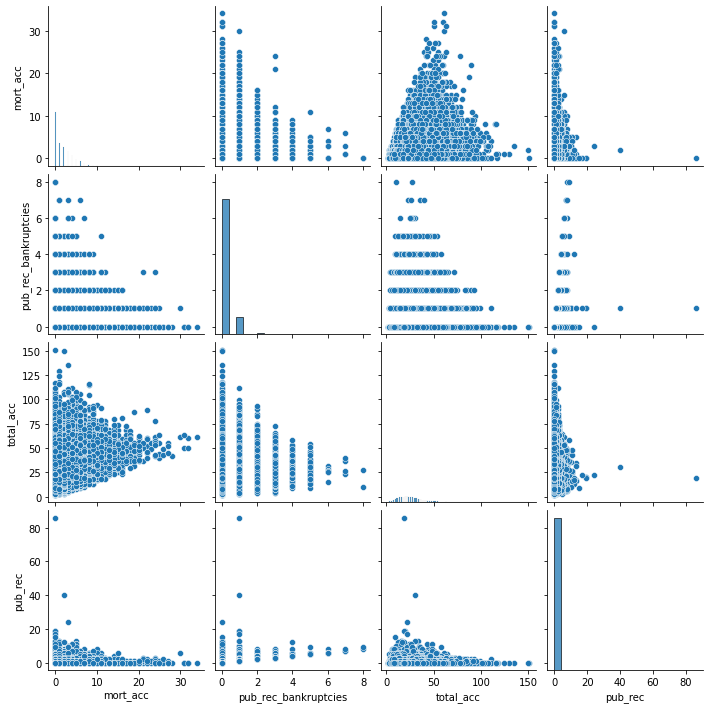

In [27]:
sns.pairplot(data=df_eda.loc[:, ['mort_acc','pub_rec_bankruptcies', 'total_acc', 'pub_rec']])

In [3]:
# https://stackoverflow.com/questions/67858871/pass-arguments-to-functiontransformer-in-pipeline

# Missing Data Imputation using Regression
def fill_missing(df, missing, features):
    _df = df.copy()
    observe = _df[_df[missing].notna()]
    
    #Create a Linear Regression model to estimate the missing data
    model = linear_model.LinearRegression()
    model.fit(X = observe[features], y = observe[missing])
    
    if missing == 'mort_acc' or missing == 'pub_rec_bankruptcies':
        dtype = 'int'
    else:
        dtype = 'float'
    
    _df.loc[_df[missing].isnull(),missing] = model.predict(_df[_df[missing].isnull()][features]).astype(dtype)
    
    #revol_util should be less than revol_bal, mort_acc less than total_acc, pub_rec_bankruptcies less than pub_rec
    if missing == 'revol_util' and len(_df[_df['revol_util']>_df['revol_bal']])>0:
        _df.loc[_df['revol_util']>_df['revol_bal'], 'revol_util'] = df['revol_bal'] / 2
    
    if  missing == 'mort_acc' and len(_df[_df['mort_acc']>_df['total_acc']])>0:
        _df.loc[_df['mort_acc']>_df['total_acc'], 'mort_acc'] = df['total_acc'] / 2
        _df['mort_acc'] = _df['mort_acc'].astype('int')
    
    if missing == 'pub_rec_bankruptcies' and len(_df[_df['pub_rec_bankruptcies']>_df['pub_rec']])>0:
        _df.loc[_df['pub_rec_bankruptcies']>_df['pub_rec'], 'pub_rec_bankruptcies'] = df['pub_rec'] / 2
        _df['pub_rec_bankruptcies'] = _df['pub_rec'].astype('int')    
    
    return _df
    


In [21]:
del df_eda

## Machine Learning
- Split data into train and test
- Build data pipeline to process train and test data
- Machine learning model selection and hyperparameter tuning
- Model evaluation
- Model ensembling

### Split data into train and test 

In [11]:
TARGET = "loan_default"
columns_predictors = [col for col in df.columns if col not in [TARGET]]
X = df[columns_predictors]
y = df[TARGET]

# Train-test split, #stratified sampling based on the target for imbalanced data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10086, stratify=y) 
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (316824, 26)
X_test.shape: (79206, 26)
y_train.shape: (316824,)
y_test.shape: (79206,)


0    254686
1     62138
Name: loan_default, dtype: int64

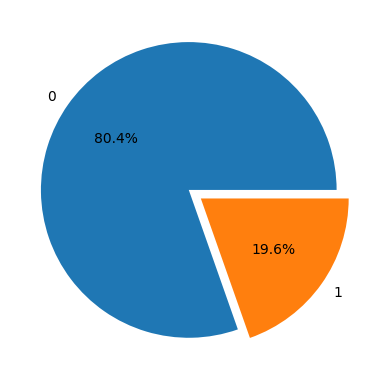

In [14]:
### Chcek 
check_data_balance(y_train, style = 'default')

### Data Processing Pipeline

- Missing Data Imputation using Regression for revol_util, mort_acc, pub_rec_bankruptcies
- Drop original target loan_status
- Drop 'grade' since grade information is included in sub_grade  #df.groupby(['grade','sub_grade']).size()
- Drop 'emp_length' and 'initial_list_status' due to low contribution.
- Drop 'installement' to avoid multicollinearity
- Drop 'title' column since it includes similar information as purpose. 
- emp_title into 4 groups with column emp_title_group <br>
        management(PRESIDENT, Executive, DIRECTOR, MANAGER, SUPERVISOR, OWNER) 
        professional(Teacher, Registered Nurse, RN, Accountant, Engineer, Analyst) 
        law (Police, Attorney) 
        Other 
- verification_status : Verified / Source Verified--1, Not Verified--0
- validate home_ownership to 4 values: RENT, OWN, MORTGAGE, OTHER, set any value not RENT, OWN, MORTGAGE as OTHER
- earliest_cr_line: extract year 
- address: only keep postcode
- one-hot encoding for all remaining categorigal features: term_month, sub_grade, purpose, application_type
- scale all remaining numeric features: 'loan_amnt', 'annual_inc', 'dti', 'open_acc'

In [5]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [6]:
drop_columns = ['loan_status', 'grade', 'emp_length', 'initial_list_status','installment','title', 'emp_title',               
               'loan_amnt',  'revol_bal', 'revol_util','annual_inc','dti','earliest_cr_line', 'open_acc',
               'pub_rec_bankruptcies', 'pub_rec','total_acc','mort_acc'                      
             #   'int_rate', 'address', 'sub_grade' , 'term', 'home_ownership', 'verification_status',  'purpose', 'application_type'                
               ]
categorical_vars = ['term','sub_grade','home_ownership', 'verification_status','purpose', \
                    'application_type', 'postcode']
discrete_vars = ['earliest_cr_line_year','open_acc','pub_rec','total_acc','mort_acc','pub_rec_bankruptcies']
continuous_vars = ['loan_amnt', 'int_rate','installment','annual_inc','dti','revol_bal','revol_util']

In [7]:
def tr_emp_title_group(df):
    _df = df.copy()
    _df['emp_title'] = _df['emp_title'].apply(get_emp_title_group)
    return _df

def validate_verification_status(df):
    _df = df.copy()
    _df['verification_status'] = _df['verification_status'].apply(lambda x:0 if x=='Not Verified' else 1 )
    return _df

def get_year(df):
    _df = df.copy()
    _df.iloc[:,0] = _df.iloc[:,0].dt.year
    return _df

def get_postcode(df):    
    _df = df.copy()
    _df['address'] = _df['address'].apply(lambda address: address[-5:])
    return _df

def validate_home_ownership(df):
    _df = df.copy()
    _df.loc[~_df['home_ownership'].isin([ 'RENT', 'OWN', 'MORTGAGE']), 'home_ownership'] = 'OTHER'
    return _df


In [15]:
#fill_missing(df, missing, features)
#temp = fill_missing(df_eda, 'mort_acc', ['total_acc'])
#temp = fill_missing(df_eda, 'pub_rec_bankruptcies', ['pub_rec'])
#temp = fill_missing(df_eda, 'revol_util', ['int_rate', 'revol_bal'])
pipeline_emp_title = Pipeline([
    ('Transfer', FunctionTransformer(tr_emp_title_group, feature_names_out='one-to-one'))
   ,('onehot', OneHotEncoder(handle_unknown="ignore"))
])

pipeline_mort_acc = Pipeline([
    ('imputation', FunctionTransformer(fill_missing, kw_args={'missing':'mort_acc', 'features':['total_acc']}, \
                                       feature_names_out='one-to-one'))
   ,('scale', MinMaxScaler(feature_range=(0,1)))
])

pipeline_pub_rec_bankruptcies = Pipeline([
    ('imputation', FunctionTransformer(fill_missing, kw_args={'missing':'pub_rec_bankruptcies', 'features':['pub_rec']}, \
                                       feature_names_out='one-to-one'))
   ,('scale', MinMaxScaler(feature_range=(0,1)))
])

pipeline_revol_util = Pipeline([
    ('imputation', FunctionTransformer(fill_missing, kw_args={'missing':'revol_util', 'features':['int_rate', 'revol_bal']}, \
                                       feature_names_out='one-to-one'))
   ,('scale', MinMaxScaler(feature_range=(0,1)))
])

pipeline_yearScale = Pipeline([
    ('getYear', FunctionTransformer(get_year, feature_names_out='one-to-one'))
   ,('scale', MinMaxScaler(feature_range=(0,1)))
])

pipeline_postcode = Pipeline([
    ('Transfer', FunctionTransformer(get_postcode, feature_names_out='one-to-one'))
   ,('onehot', OneHotEncoder(handle_unknown="ignore"))
])

pipeline_home_owner = Pipeline([
    ('Transfer', FunctionTransformer(validate_home_ownership, feature_names_out='one-to-one'))
   ,('onehot', OneHotEncoder(handle_unknown="ignore"))
])

pipeline_scaler = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0,1)))
])

pipeline_oneHot = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

pipeline_ordinal = Pipeline([
    ('ordinal', OrdinalEncoder(categories=[['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5']]))
    ,('scaler', MinMaxScaler(feature_range=(0,1)))
])

pipeline_predictor = ColumnTransformer([
    ('column_dropper', 'drop', drop_columns),
##    ("TransferOnehot",  pipeline_emp_title, ["emp_title"]),
#    ("imputScaleMort",  pipeline_mort_acc, ['mort_acc','total_acc']),
#    ("imputScalePub",  pipeline_pub_rec_bankruptcies, ['pub_rec_bankruptcies','pub_rec']),
#    ("imputScaleRevo",  pipeline_revol_util, ['revol_util','int_rate', 'revol_bal']),
    ("scaler", pipeline_scaler, ['int_rate']),
    ("validate_verification", FunctionTransformer(validate_verification_status, feature_names_out='one-to-one'), ["verification_status"]),
#    ("year_earliest_cr_line", pipeline_yearScale, ["earliest_cr_line"]),
    ("postCode",  pipeline_postcode, ["address"]),
    ('home_owner', pipeline_home_owner, ['home_ownership']),
#    ("scaler", pipeline_scaler, ['loan_amnt', 'annual_inc', 'dti', 'open_acc']),
    ("oneHot", pipeline_oneHot, ['term', 'purpose', 'application_type']),
#    ("oneHot", pipeline_oneHot, ['term']),
    ("ordinal", pipeline_ordinal, ['sub_grade'])
], remainder='passthrough')

#pipeline_predictor.set_output(transform="pandas")
pipeline_predictor.fit(X_train)
X_train_transformed = pipeline_predictor.transform(X_train)
X_test_transformed = pipeline_predictor.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")

X_train_transformed.shape: (316824, 36)
X_test_transformed.shape: (79206, 36)


In [14]:
temp = X_train_transformed.todense()[0]
temp

matrix([[0.23957928, 1.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 1.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.26470588]])

In [67]:
X_train.iloc[0:5,[2,5,25]]

,int_rate,sub_grade,address
213606,11.47,B5,"08092 Wood Creek Suite 799\r\nJohnsonhaven, CA 70466"
204823,12.05,C1,"37964 Chavez Fort Suite 268\r\nEast Robert, GA 22690"
150465,13.18,C3,"63856 Ellis Crossing\r\nMartineztown, DE 00813"
57507,12.99,C1,"981 Randy Creek Apt. 683\r\nGeorgeland, CO 30723"
36157,5.32,A1,"0653 Gabriel Knoll Apt. 915\r\nRussoberg, NH 48052"


In [16]:
pipeline_predictor

ColumnTransformer(remainder='passthrough',
                  transformers=[('column_dropper', 'drop',
                                 ['loan_status', 'grade', 'emp_length',
                                  'initial_list_status', 'installment', 'title',
                                  'emp_title', 'loan_amnt', 'revol_bal',
                                  'revol_util', 'annual_inc', 'dti',
                                  'earliest_cr_line', 'open_acc',
                                  'pub_rec_bankruptcies', 'pub_rec',
                                  'total_acc', 'mort_acc']),
                                ('scaler',
                                 Pipeline(steps=[('scale...
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['term', 'purpose', 'application_type']),
                                ('ordinal',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder(categories=[['A1',
                                                                              'A2',
                                                                              'A3',
                                                                              'A4',
                                                                              'A5',
                                                                              'B1',
                                                                              'B2',
                                                                              'B3',
                                                                              'B4',
                                                                              'B5',
                                                                              'C1',
                                                                              'C2',
                                                                              'C3',
                                                                              'C4',
                                                                              'C5',
                                                                              'D1',
                                                                              'D2',
                                                                              'D3',
                                                                              'D4',
                                                                              'D5',
                                                                              'E1',
                                                                              'E2',
                                                                              'E3',
                                                                              'E4',
                                                                              'E5',
                                                                              'F1',
                                                                              'F2',
                                                                              'F3',
                                                                              'F4',
                                                                              'F5', ...]])),
                                                 ('scaler', MinMaxScaler())]),
                                 ['sub_grade'])])

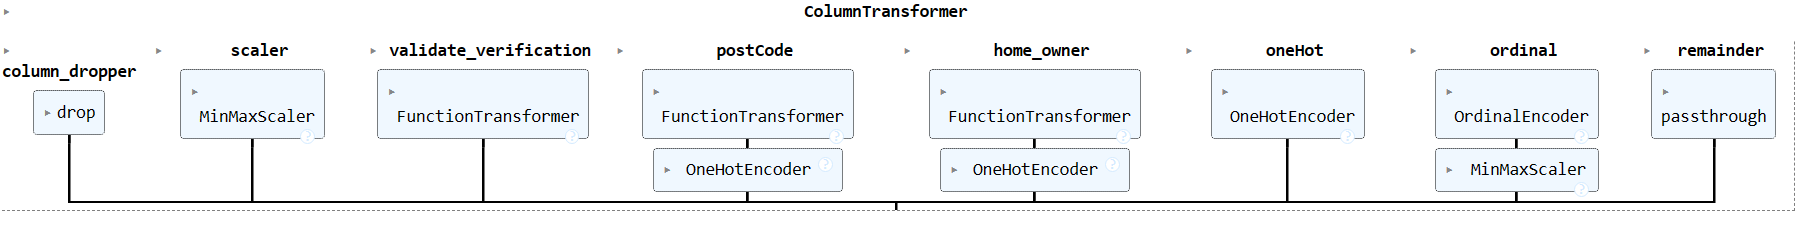

In [20]:
pipeline_predictor.get_feature_names_out()

array(['scaler__int_rate', 'validate_verification__verification_status',
       'postCode__address_00813', 'postCode__address_05113',
       'postCode__address_11650', 'postCode__address_22690',
       'postCode__address_29597', 'postCode__address_30723',
       'postCode__address_48052', 'postCode__address_70466',
       'postCode__address_86630', 'postCode__address_93700',
       'home_owner__home_ownership_MORTGAGE',
       'home_owner__home_ownership_OTHER',
       'home_owner__home_ownership_OWN',
       'home_owner__home_ownership_RENT', 'oneHot__term_ 36 months',
       'oneHot__term_ 60 months', 'oneHot__purpose_car',
       'oneHot__purpose_credit_card',
       'oneHot__purpose_debt_consolidation',
       'oneHot__purpose_educational', 'oneHot__purpose_home_improvement',
       'oneHot__purpose_house', 'oneHot__purpose_major_purchase',
       'oneHot__purpose_medical', 'oneHot__purpose_moving',
       'oneHot__purpose_other', 'oneHot__purpose_renewable_energy',
       'oneHot_

### Cross-validation and hyperparameters tuning
- Stratified K-fold cross-validation for imbalanced data

In [17]:
def model_evalation(model, X_train, X_test, y_train, y_test, probability, ANN):
    # predict_proba() return the list of probability for each class.Binary class gets two dimensions for class 0 and 1, 
    # to get the probability of class1, need to use arry from second dimension which is [:,1]
    if probability:
        x_train_preds = model.predict_proba(X_train)
        x_test_preds = model.predict_proba(X_test)
    
    x_train_pred = model.predict(X_train)
    if ANN:
            x_train_pred = tf.squeeze(x_train_pred)
            x_train_pred = np.array([1 if x >= 0.5 else 0 for x in x_train_pred])
    
    x_test_pred = model.predict(X_test)
    if ANN:
        x_test_pred = tf.squeeze(x_test_pred)
        x_test_pred = np.array([1 if x >= 0.5 else 0 for x in x_test_pred])

    if probability:
        print('Train roc_auc:', roc_auc_score(y_train, x_train_preds[:,1]))
        print('Test roc_auc:', roc_auc_score(y_test, x_test_preds[:,1]))
    
    print(f"Train accuracy_score: {accuracy_score(y_train, x_train_pred)}")
    print(f"Test accuracy_score: {accuracy_score(y_test, x_test_pred)}")
    
    print(f"Train precision_score: {precision_score(y_train, x_train_pred)}")
    print(f"precision_score: {precision_score(y_test, x_test_pred)}")
    print(f"Train recall_score: {recall_score(y_train, x_train_pred)}")
    print(f"Test recall_score: {recall_score(y_test, x_test_pred)}")
    print(f"Train f1_score: {f1_score(y_train, x_train_pred)}")
    print(f"Test f1_score: {f1_score(y_test, x_test_pred)}")
    #print(confusion_matrix(y_true, y_pred)
    print(f"Train confusion_matrix: {confusion_matrix(y_train, x_train_pred)}")
    print(f"Test confusion_matrix: {confusion_matrix(y_test, x_test_pred)}")

### RandomForestClassifier

In [18]:
clf_rdf = RandomForestClassifier(random_state=0)

# GridSearch need parameter space of specific parameter value sets
# RandommizedSearch need parameter space of parameter distibution range to maximize the power of RandomSearch. 
param_grid = dict(
    n_estimators = stats.randint(10,120),
    min_samples_split = stats.uniform(0,1),
    max_depth = stats.randint(1,20)
)

skf = StratifiedKFold(5, shuffle=True, random_state=4)
    
search = RandomizedSearchCV(estimator=clf_rdf, 
                             param_distributions=param_grid,
                             scoring='recall',
                             cv=skf,
                             n_iter=90, 
                             random_state=10,
                             n_jobs=6,
                             refit=True)

time_start = time.time()
search.fit(X_train_transformed, y_train)
print('RandomizedSearch Time elapsed:  --- %s seconds -- '%(time.time()-time_start))

RandomizedSearch Time elapsed:  --- 922.0133390426636 seconds -- 


In [19]:
clf_rdf_params = search.best_params_
search.best_params_

{'max_depth': 13, 'min_samples_split': 0.10540183348780108, 'n_estimators': 67}

In [45]:
results = pd.DataFrame(search.cv_results_)
results.sort_values(by='mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)

Text(0.5, 0, 'Hyperparameter combinations')

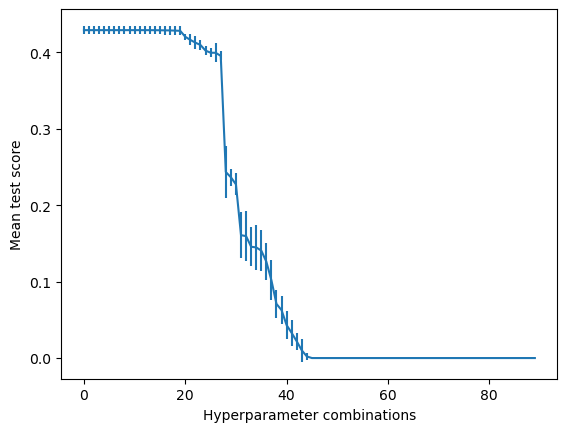

In [46]:
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [47]:
final_model = search.best_estimator_
model_evalation(final_model, X_train_transformed, X_test_transformed, y_train, y_test, True, False)

Train roc_auc: 0.8824836051890448
Test roc_auc: 0.8813787283768659
Train accuracy_score: 0.8880387849405348
Test accuracy_score: 0.8883544175946266
Train precision_score: 1.0
precision_score: 1.0
Train recall_score: 0.4291415880781486
Test recall_score: 0.4307692307692308
Train f1_score: 0.6005585333993964
Test f1_score: 0.6021505376344086
Train confusion_matrix: [[254686      0]
 [ 35472  26666]]
Test confusion_matrix: [[63671     0]
 [ 8843  6692]]


In [20]:
search.best_estimator_

RandomForestClassifier(max_depth=13, min_samples_split=0.10540183348780108,
                       n_estimators=67, random_state=0)

#### <br>feature importance
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

Calculating feature importance Time elapsed:  --- 39.81600832939148 seconds -- 


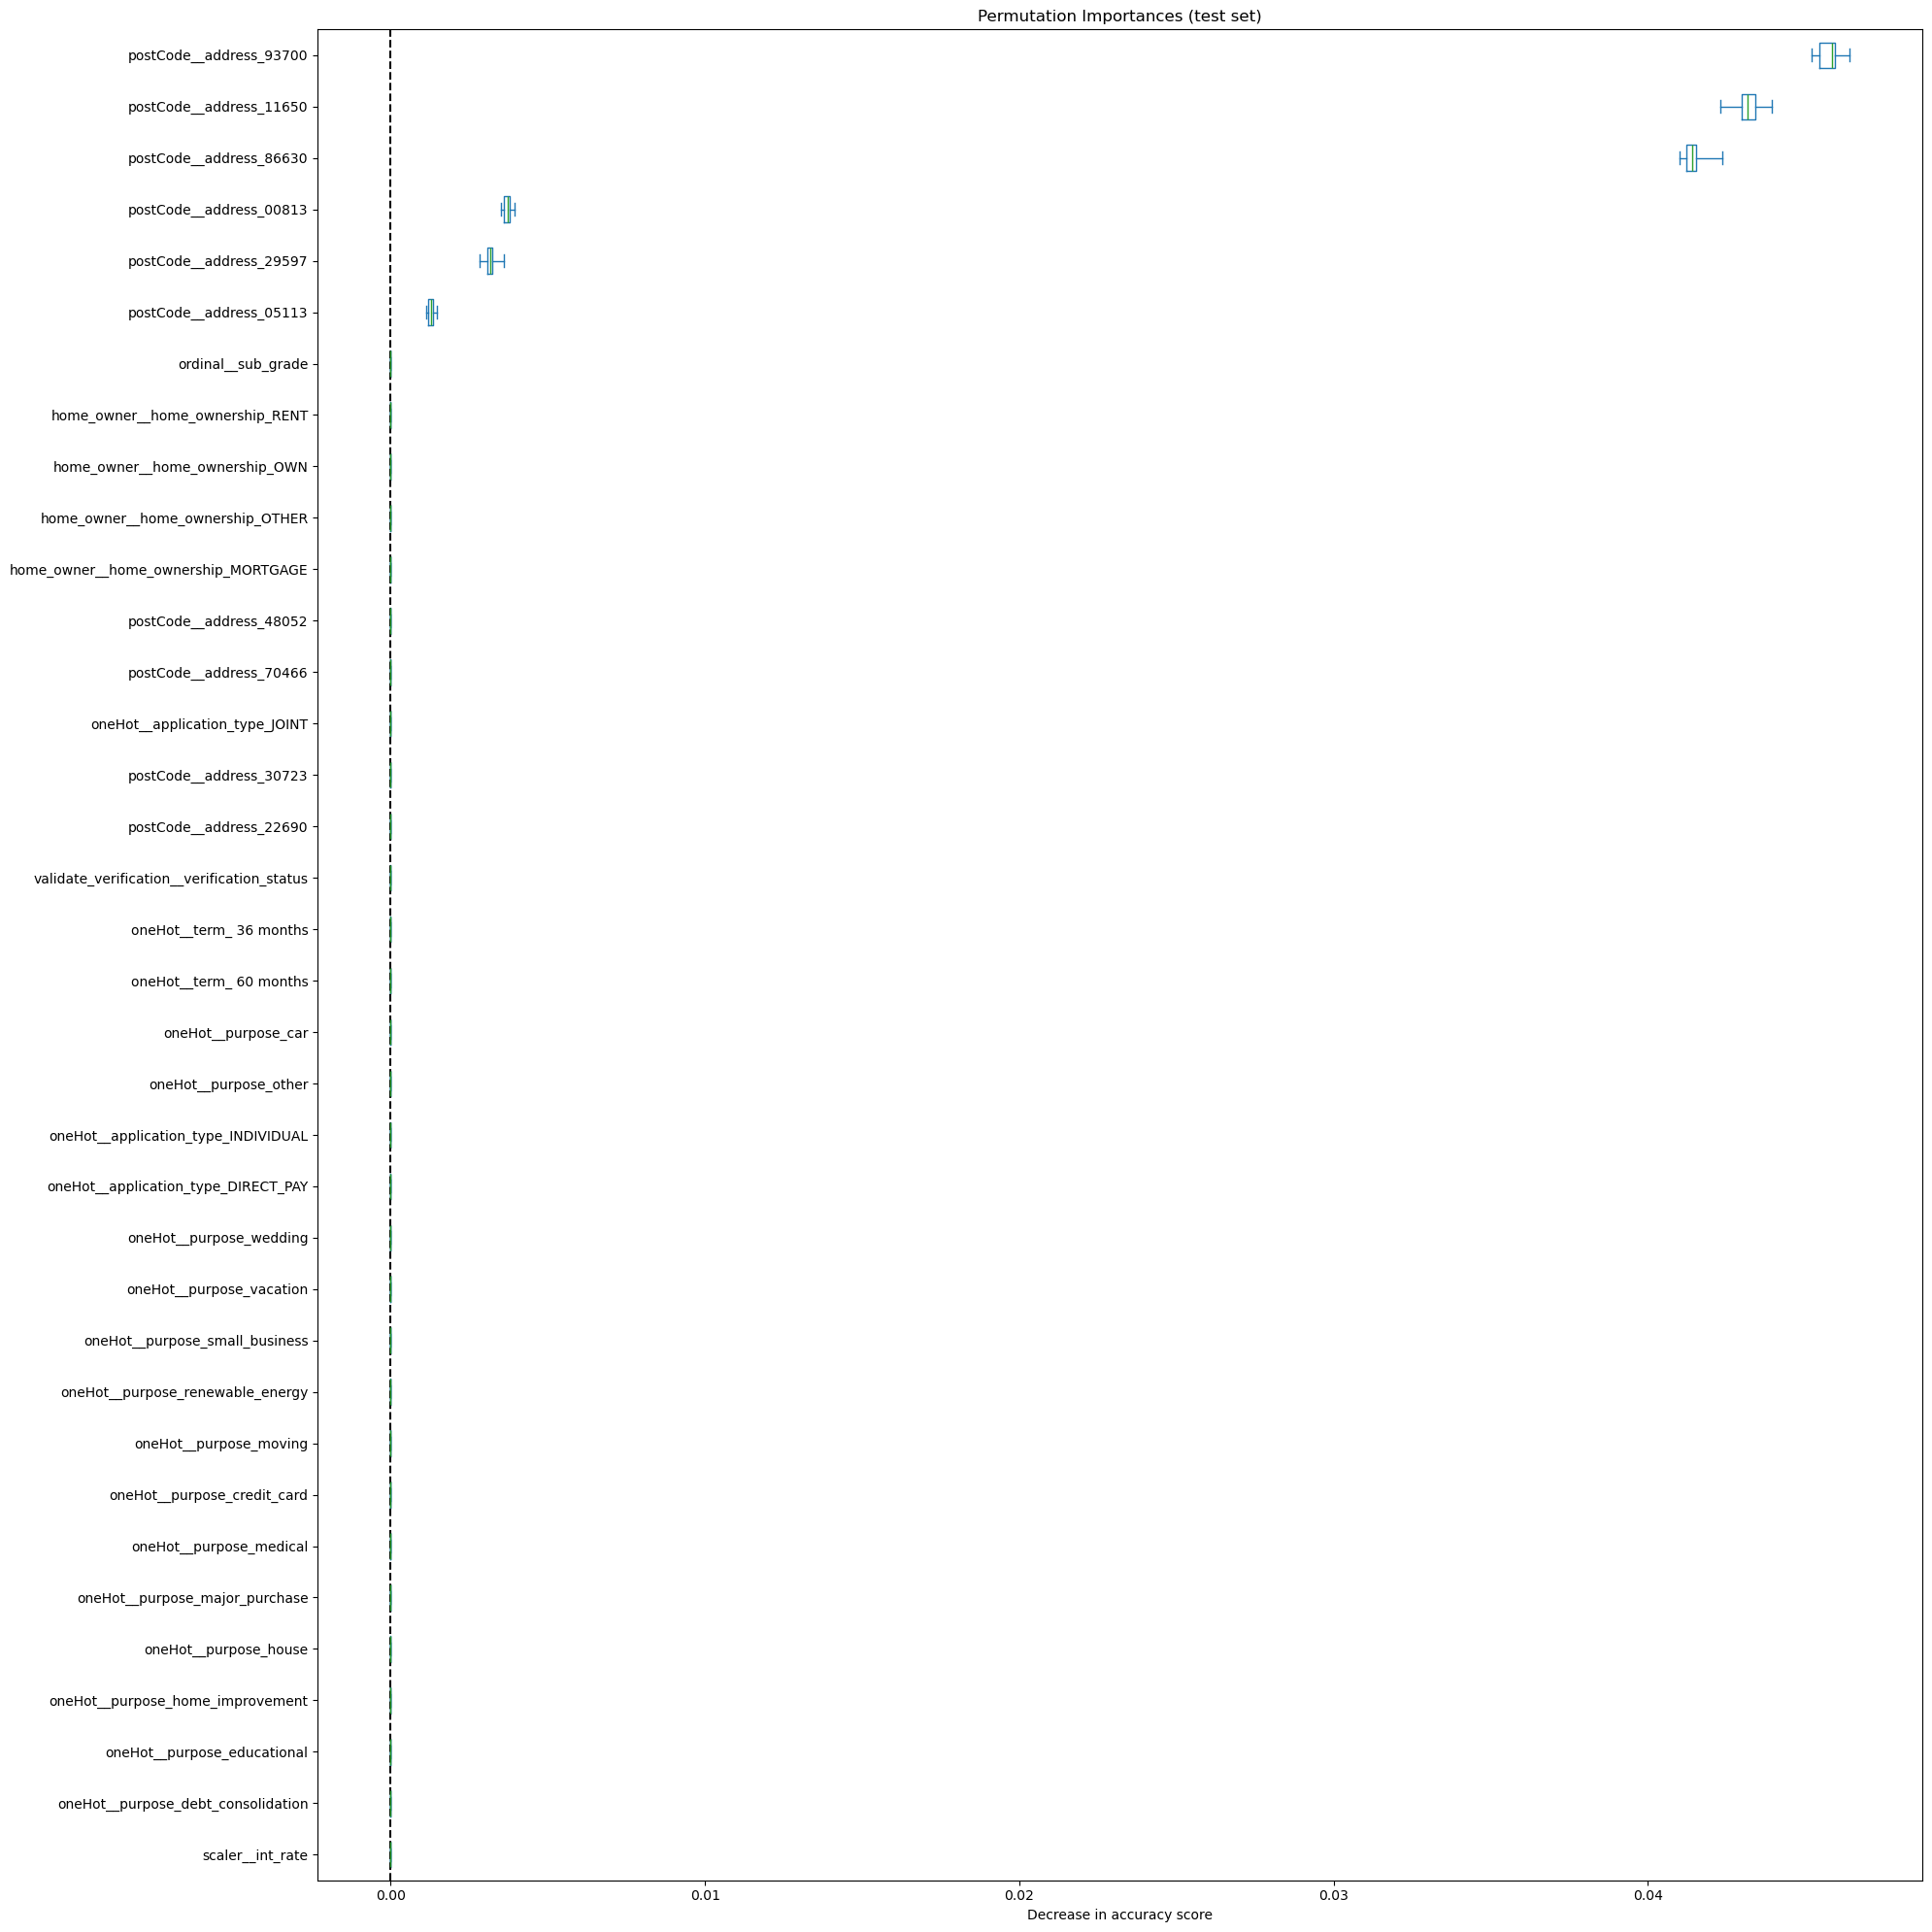

In [48]:
time_start = time.time()

result = permutation_importance(
    final_model, X_test_transformed.toarray(), y_test, n_repeats=10, random_state=42, n_jobs=6
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=[pipeline_predictor.get_feature_names_out()[i] for i in result.importances_mean.argsort()]  
)
ax = importances.plot.box(vert=False, whis=10, figsize = (20,20))
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

print('Calculating feature importance Time elapsed:  --- %s seconds -- '%(time.time()-time_start))

### Logistic Regression

In [40]:
cls_lgr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=300).fit(X_train_transformed, y_train)
model_evalation(cls_lgr, X_train_transformed, X_test_transformed, y_train, y_test, True, False)

Train roc_auc: 0.9017003145561403
Test roc_auc: 0.9009507920749082
Train accuracy_score: 0.8875243037143651
Test accuracy_score: 0.8875842739186425
Train precision_score: 0.9246867288401757
precision_score: 0.9234895899859497
Train recall_score: 0.4643374424667675
Test recall_score: 0.46540070807853234
Train f1_score: 0.6182277884316646
Test f1_score: 0.6189008731381612
Train confusion_matrix: [[252336   2350]
 [ 33285  28853]]
Test confusion_matrix: [[63072   599]
 [ 8305  7230]]


### SVM
https://marcovirgolin.github.io/extras/details_time_complexity_machine_learning_algorithms/

In [40]:
# model with svm default parameters' values
cls_svm_default = SVC().fit(X_train_transformed, y_train)
model_evalation(cls_svm_default, X_train_transformed, X_test_transformed, y_train, y_test, False)

Train accuracy_score: 0.8880387849405348
Test accuracy_score: 0.8883544175946266
Train precision_score: 1.0
precision_score: 1.0
Train recall_score: 0.4291415880781486
Test recall_score: 0.4307692307692308
Train f1_score: 0.6005585333993964
Test f1_score: 0.6021505376344086
Train confusion_matrix: [[254686      0]
 [ 35472  26666]]
Test confusion_matrix: [[63671     0]
 [ 8843  6692]]


In [23]:
time_start = time.time()
cls_svm = SVC(kernel = 'linear', C=1.0).fit(X_train_transformed, y_train)
print('Calculating SVM model training Time elapsed:  --- %s seconds -- '%(time.time()-time_start))
model_evalation(cls_svm, X_train_transformed, X_test_transformed, y_train, y_test, False, False)
print('Calculating SVM model evaluation Time elapsed:  --- %s seconds -- '%(time.time()-time_start))

Calculating SVM model training Time elapsed:  --- 731.7827615737915 seconds -- 
Train accuracy_score: 0.8880387849405348
Test accuracy_score: 0.8883544175946266
Train precision_score: 1.0
precision_score: 1.0
Train recall_score: 0.4291415880781486
Test recall_score: 0.4307692307692308
Train f1_score: 0.6005585333993964
Test f1_score: 0.6021505376344086
Train confusion_matrix: [[254686      0]
 [ 35472  26666]]
Test confusion_matrix: [[63671     0]
 [ 8843  6692]]
Calculating SVM model evaluation Time elapsed:  --- 1175.212968826294 seconds -- 


### ANN

- Sequential is a type of model in Keras that allows you to create neural networks layer by layer in a sequential manner. Each layer is added on top of the previous one.
- Dense is a type of layer in Keras, representing a fully connected layer. It has 36 units, which means it has 36 neurons.
- Input Layer need to have the same number of neurons as the number of features.


In [25]:
time_start = time.time()
cls_ANN = Sequential()

# input layer
cls_ANN.add(Dense(36,  activation='relu'))
cls_ANN.add(Dropout(0.2))

# hidden layer
cls_ANN.add(Dense(17, activation='relu'))
cls_ANN.add(Dropout(0.2))

# output layer
cls_ANN.add(Dense(units=1,activation='sigmoid'))

# Compile model
cls_ANN.compile(loss='binary_crossentropy', optimizer='adam')

cls_ANN.fit(x=X_train_transformed, 
          y=y_train, 
          epochs=25,
          batch_size=256,
          validation_data=(X_test_transformed, y_test), 
          )
print('Calculating ANN model Time elapsed:  --- %s seconds -- '%(time.time()-time_start))

Epoch 1/25
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3893 - val_loss: 0.2615
Epoch 2/25
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2675 - val_loss: 0.2611
Epoch 3/25
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.2650 - val_loss: 0.2605
Epoch 4/25
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2642 - val_loss: 0.2610
Epoch 5/25
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2648 - val_loss: 0.2606
Epoch 6/25
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.2602 - val_loss: 0.2603
Epoch 7/25
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2625 - val_loss: 0.2602
Epoch 8/25
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2618 - val_loss: 0.2603
Epoch 9/25
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2612 - val_loss: 0.2605
Epoch 10/25
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2612 - val_loss: 0.2603
Epoch 11/25
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2617 - val_loss: 0.2606
Epoch 12/25
1238/1238 ━━━━━━

In [21]:
X_train_transformed

<316824x36 sparse matrix of type '<class 'numpy.float64'>'
	with 2424895 stored elements in Compressed Sparse Row format>

<AxesSubplot:>

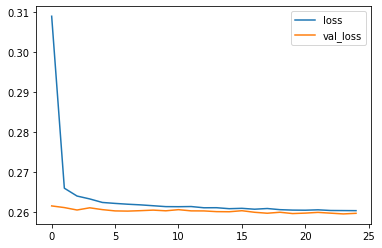

In [26]:
losses = pd.DataFrame(cls_ANN.history.history)
losses[['loss','val_loss']].plot()

In [39]:
model_evalation(cls_ANN, X_train_transformed, X_test_transformed, y_train, y_test, False, True)

9901/9901 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step
2476/2476 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Train accuracy_score: 0.8880924424917305
Test accuracy_score: 0.888417544125445
Train precision_score: 0.9974644841343824
precision_score: 0.9976222321295883
Train recall_score: 0.430509511088223
Test recall_score: 0.43212101705825556
Train f1_score: 0.6014366491675753
Test f1_score: 0.6030362917714697
Train confusion_matrix: [[254618     68]
 [ 35387  26751]]
Test confusion_matrix: [[63655    16]
 [ 8822  6713]]


## Conclusion
- Ordinal categorical features can encoded with either label encoding or one_hot encoding. Depends on the dataset and solution target, there can be slightly perforamance difference with these two approaches, in this project label encoding is a little better than one_hot encoding.
- Feature selection: implement Forward stepwise selection. Eventually 'int_rate', 'address', 'sub_grade' , 'term', 'home_ownership', 'verification_status',  'purpose', 'application_type'  are the features been selected.
- RandomForestClassifier has low torlerance on reduantant/random/low contribution features, which can confuse the model and ends up with worse performance, numeric and high cardinaity categorical feature has higher impact to reduce prediction power.
- LogisticRegression is efficient and won't get confused with reduantant feature on accuracy, but will increase model compexicity.
- SVM has high computational complexity between O(n^2m) and O(n^3m), take quite long to train the model, not a good choice for large volume data. 
- With good feature selection and necessary hyperparameter tuning, all 4 models (RandomForestClassifier, Logistic Regression, SVM and ANN) can get similar prediction performance. 